In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision, Time Series, and Survival Analysis (Lectures 18 to 20)

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

There are 108 Different time series. We have a seperate measurment for each combination of region / type.

In [9]:
region_and_type = list(zip(df_train['region'], df_train['type']))


region_and_type = set(region_and_type)

region_and_type

{('Albany', 'conventional'),
 ('Albany', 'organic'),
 ('Atlanta', 'conventional'),
 ('Atlanta', 'organic'),
 ('BaltimoreWashington', 'conventional'),
 ('BaltimoreWashington', 'organic'),
 ('Boise', 'conventional'),
 ('Boise', 'organic'),
 ('Boston', 'conventional'),
 ('Boston', 'organic'),
 ('BuffaloRochester', 'conventional'),
 ('BuffaloRochester', 'organic'),
 ('California', 'conventional'),
 ('California', 'organic'),
 ('Charlotte', 'conventional'),
 ('Charlotte', 'organic'),
 ('Chicago', 'conventional'),
 ('Chicago', 'organic'),
 ('CincinnatiDayton', 'conventional'),
 ('CincinnatiDayton', 'organic'),
 ('Columbus', 'conventional'),
 ('Columbus', 'organic'),
 ('DallasFtWorth', 'conventional'),
 ('DallasFtWorth', 'organic'),
 ('Denver', 'conventional'),
 ('Denver', 'organic'),
 ('Detroit', 'conventional'),
 ('Detroit', 'organic'),
 ('GrandRapids', 'conventional'),
 ('GrandRapids', 'organic'),
 ('GreatLakes', 'conventional'),
 ('GreatLakes', 'organic'),
 ('HarrisburgScranton', 'convent

In [10]:
len(region_and_type)

108

In [11]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

The measurements were taken at even 7-day intervals. We can see this because when time is sorted, the difference between one time-of-measurement and the next is always a huge negative number or a multiple of 7 days. Since we sorted on days, the huge negative number must be the end of region/type series and the start of another one.

The fact that we sometimes see 14 or 21 days instead of always 7 means that occasionally, a measurement was missed.

In [12]:
diffs = []

time_region_and_type = list(zip(df_train['Date'], df_train['region'], df_train['type']))
time_region_and_type = sorted(time_region_and_type, key=lambda x: x[0])
time_region_and_type = sorted(time_region_and_type, key=lambda x: x[2])
time_region_and_type = sorted(time_region_and_type, key=lambda x: x[1])

In [13]:

for i in range(len(time_region_and_type) - 1):
    diffs.append(time_region_and_type[i + 1][0] - time_region_and_type[i][0])

set(diffs)

{Timedelta('-994 days +00:00:00'),
 Timedelta('7 days 00:00:00'),
 Timedelta('14 days 00:00:00'),
 Timedelta('21 days 00:00:00')}

In [14]:
...

Ellipsis

In [15]:
...

Ellipsis

In [16]:
...

Ellipsis

In [17]:
...

Ellipsis

In [18]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [19]:
(df[df['region'] == 'Northeast'].iloc[0]['Total Volume']) / (df[df['region'] == 'Albany'].iloc[0]['Total Volume'])

49.136461414065685

In [20]:
...

Ellipsis

In [21]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [22]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [23]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [24]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [25]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

$R^2$ for train is 0.8285. $R^2$ for test_df is 0.76.

In [26]:
train_r2 = r2_score(df_train['AveragePriceNextWeek'], df_train['AveragePrice'])

train_r2

0.8285800937261841

In [27]:
test_r2 = r2_score(df_test['AveragePriceNextWeek'], df_test['AveragePrice'])

test_r2

0.7631780188583048

In [28]:
...

Ellipsis

In [29]:
...

Ellipsis

In [30]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

I saw that varying time of day seemed to help the bike dataset, so I tried a similar thing here. I didn't want to try too many categories with days, so I just stuck with month.

I decided to drop region as well. I was worried dividing things up that much risked overfitting.

/tmp/ipykernel_1732205/402212665.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_Y = df_train[df_train['region'] == 'Albany'][df_train['type'] == 'conventional']['AveragePrice']
/tmp/ipykernel_1732205/402212665.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_X = df_train[df_train['region'] == 'Albany'][df_train['type'] == 'conventional']['Date']
/tmp/ipykernel_1732205/402212665.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_Y = df_test[df_test['region'] == 'Albany'][df_test['type'] == 'conventional']['AveragePrice']
/tmp/ipykernel_1732205/402212665.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_X = df_test[df_test['region'] == 'Albany'][df_test['type'] == 'conventional']['Date']


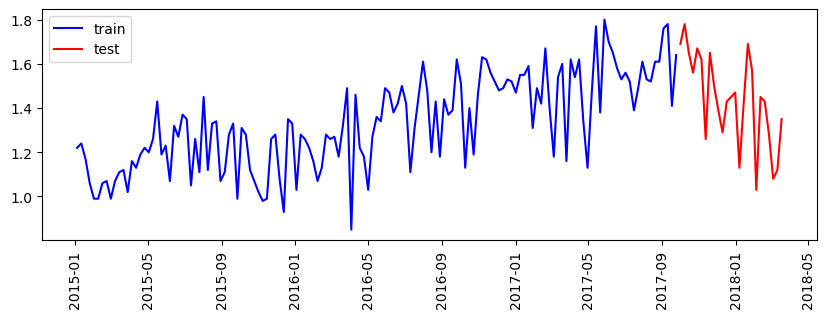

In [31]:
plt.figure(figsize=(10, 3))

train_Y = df_train[df_train['region'] == 'Albany'][df_train['type'] == 'conventional']['AveragePrice']
train_X = df_train[df_train['region'] == 'Albany'][df_train['type'] == 'conventional']['Date']
test_Y = df_test[df_test['region'] == 'Albany'][df_test['type'] == 'conventional']['AveragePrice']
test_X = df_test[df_test['region'] == 'Albany'][df_test['type'] == 'conventional']['Date']


plt.plot(train_X, train_Y, "b", label="train")
plt.plot(test_X, test_Y, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

In [32]:
copied_train = df_train.copy()

copied_train = copied_train.drop(columns=['AveragePriceNextWeek', 'region'])

copied_train

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017


In [33]:
copied_test = df_test.copy()
copied_test = copied_test.drop(columns=['AveragePriceNextWeek',  'region'])

copied_test

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
143,2017-10-01,1.69,71205.11,4411.02,57416.25,77.85,9299.99,5069.66,4230.33,0.0,conventional,2017
144,2017-10-08,1.78,55368.61,3679.82,45843.75,42.63,5802.41,2148.20,3654.21,0.0,conventional,2017
145,2017-10-15,1.65,73574.89,3383.35,63355.37,62.45,6773.72,3882.02,2891.70,0.0,conventional,2017
146,2017-10-22,1.56,69704.09,3758.80,57340.30,35.48,8569.51,5101.64,3467.87,0.0,conventional,2017
147,2017-10-29,1.67,69432.23,2959.76,57585.49,57.94,8829.04,5050.91,3778.13,0.0,conventional,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018


In [34]:
copied_train['Date'] = pd.to_datetime(df_train['Date'])
copied_train['Month'] = copied_train['Date'].dt.month
copied_train['Day'] = copied_train['Date'].dt.day
copied_train['WeekOfMonth'] = (copied_train['Date'].dt.day - 1) // 7 + 1
copied_train['Date'] = copied_train['Date'].astype('int64') // 10**9


train_target = df_train['AveragePriceNextWeek']

copied_train

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,Month,Day,WeekOfMonth
0,1420329600,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,1,4,1
1,1420934400,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,1,11,2
2,1421539200,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,1,18,3
3,1422144000,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,1,25,4
4,1422748800,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,1503792000,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,8,27,4
18219,1504396800,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,9,3,1
18220,1505001600,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,9,10,2
18221,1505606400,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,9,17,3


In [35]:
copied_test['Date'] = pd.to_datetime(df_test['Date'])
copied_test['Month'] = copied_test['Date'].dt.month
copied_test['Day'] = copied_test['Date'].dt.day
copied_test['WeekOfMonth'] = (copied_test['Date'].dt.day - 1) // 7 + 1
copied_test['Date'] = copied_test['Date'].astype('int64') // 10**9

test_target = df_test['AveragePriceNextWeek']

copied_test

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,Month,Day,WeekOfMonth
143,1506816000,1.69,71205.11,4411.02,57416.25,77.85,9299.99,5069.66,4230.33,0.0,conventional,2017,10,1,1
144,1507420800,1.78,55368.61,3679.82,45843.75,42.63,5802.41,2148.20,3654.21,0.0,conventional,2017,10,8,2
145,1508025600,1.65,73574.89,3383.35,63355.37,62.45,6773.72,3882.02,2891.70,0.0,conventional,2017,10,15,3
146,1508630400,1.56,69704.09,3758.80,57340.30,35.48,8569.51,5101.64,3467.87,0.0,conventional,2017,10,22,4
147,1509235200,1.67,69432.23,2959.76,57585.49,57.94,8829.04,5050.91,3778.13,0.0,conventional,2017,10,29,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,1518912000,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,2,18,3
18244,1519516800,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,2,25,4
18245,1520121600,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,3,4,1
18246,1520726400,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,3,11,2


In [36]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)


In [37]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

categorical_transformer = make_pipeline(OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False))
binary_transformer = OneHotEncoder(categories=[['conventional', 'organic']], dtype=int, drop='if_binary')
numeric_transformer = StandardScaler()
categorical_transformer = make_pipeline(OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False))


categorical_features = ['Month']
binary_features = ['type',]
pass_features = ['AveragePrice', 'Month', 'Day', 'Date']

numerical_features = [c for c in copied_train.columns if not (c in pass_features or c in binary_features)]

preprocessor = make_column_transformer((numeric_transformer, numerical_features), 
                                       (categorical_transformer, categorical_features),
                                       (binary_transformer, binary_features), 
                                       remainder = 'passthrough'                                       
                                      ) 

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Total Volume', '4046', '4225', '4770',
                                  'Total Bags', 'Small Bags', 'Large Bags',
                                  'XLarge Bags', 'year', 'WeekOfMonth']),
                                ('pipeline',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Month']),
                                ('onehotencoder',
                                 OneHotEncoder(categories=[['conventional',
                                                            'organic']],
                                               drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['type'])])

In [38]:
processed_train = (preprocessor.fit_transform(copied_train))

In [39]:
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(random_state = 123)


forest.fit(processed_train, train_target)

forest.score(processed_train, train_target)


0.9801991209455678

In [40]:
processed_test = (preprocessor.transform(copied_test))


forest.score(processed_test, test_target)

0.733737228956817

In [41]:
regressor = Ridge()

regressor.fit(processed_train, train_target)

regressor.score(processed_train, train_target)


/home/roy/.local/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.61875e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


0.8439441598810506

In [42]:
regressor.score(processed_test, test_target)

0.7964939819112453

In [43]:
...

Ellipsis

In [44]:
...

Ellipsis

In [45]:
...

Ellipsis

In [46]:
...

Ellipsis

In [47]:
...

Ellipsis

In [48]:
...

Ellipsis

In [49]:
...

Ellipsis

In [50]:
...

Ellipsis

In [51]:
...

Ellipsis

In [52]:
...

Ellipsis

In [53]:
...

Ellipsis

In [54]:
...

Ellipsis

In [55]:
...

Ellipsis

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. Goals scored by a pro hockey player. Since the summer is the offseason, nobody will bother to gather data on those days.
2. Lagged versions would struggle more. When data is nicely periodic, this can clearly mean "time from X time ago". That meaning is lost when data is staggered.
3. A linear function can only learn a linear relation, so periodicity throught the day is inaccessible. This was fixed by making time of day a categorical feature. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. There will be 44 parameters; one coef from each feature-class pair, and one intercept for each class.
2. We are able to take the very last layer's values, right before the prediction, and treat is as features in a linear model with our own custom classes.
3. I'd feed each image into an off the shelf neural network. I'd extract the very last layer before the prediction, and treat is as a feature. I'd then take those features, and input it inot a Logistic regression class. I don't feel comfortable training a network from scratch given such large inputs (images), training a neural network with this little data isn't enough, and we can't use "off the shelf" as is because the labels won't be right for our purposes.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. You get a lot of right censoring; recently joined people who haven't had a chance to go thorugh the full customer lifecycle.
2. We don't have enough information. This is asking "Is the expected remaining time before churn given that they have used it for a year larger than the average customer lifespan?" Depending on context, the answer could be either.
3. The customer is very unlikely to unsubscribe during that time period.

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)